# Installing dependencies and setting GPU for faster processes.

In [ ]:
!pip install ultralytics
!pip install opencv-python-headless
!pip install gradio

In [2]:
import torch
print(torch.cuda.is_available())


True


# Ready the Dataset.

In [3]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 36.72 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [4]:
import os

# Check directory contents
dataset_path = '/content/BCCD_Dataset'
print(os.listdir(dataset_path))


['BCCD', 'plot.py', '.gitignore', 'export.py', 'example.jpg', 'scripts', 'LICENSE', 'test.csv', '.git', 'README.md', 'dataset']


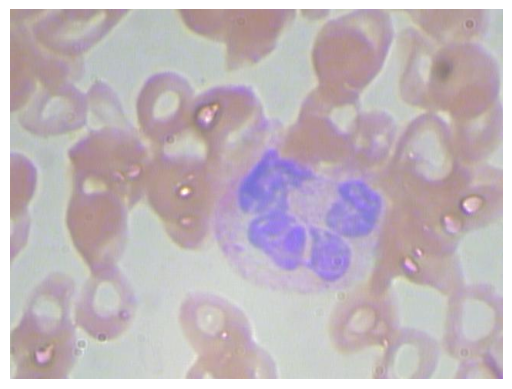

In [5]:
import cv2
from matplotlib import pyplot as plt

# Load and display a sample image
img = cv2.imread('/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00000.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [6]:
import os

annotation_dir = '/content/BCCD_Dataset/BCCD/Annotations'
print(os.listdir(annotation_dir)[:5])  # Display first 5 annotation files


['BloodImage_00231.xml', 'BloodImage_00296.xml', 'BloodImage_00232.xml', 'BloodImage_00287.xml', 'BloodImage_00134.xml']


In [7]:
# Convert XML Annotations to YOLO Format.
import xml.etree.ElementTree as ET
import os

# Define paths
annotations_path = '/content/BCCD_Dataset/BCCD/Annotations'
images_path = '/content/BCCD_Dataset/BCCD/JPEGImages'
labels_path = '/content/BCCD_Dataset/BCCD/labels'

# Create labels directory if it doesn't exist
os.makedirs(labels_path, exist_ok=True)

# Define class mapping
classes = ["platelets", "RBC", "WBC"]

def convert_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_file = xml_file.split('/')[-1].replace(".xml", ".jpg")
    image_path = os.path.join(images_path, image_file)

    # Read image to get width and height
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    label_file = os.path.join(labels_path, xml_file.split('/')[-1].replace(".xml", ".txt"))

    with open(label_file, 'w') as f:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            x_min = int(xmlbox.find('xmin').text)
            x_max = int(xmlbox.find('xmax').text)
            y_min = int(xmlbox.find('ymin').text)
            y_max = int(xmlbox.find('ymax').text)

            # Normalize coordinates
            x_center = ((x_min + x_max) / 2) / w
            y_center = ((y_min + y_max) / 2) / h
            bbox_width = (x_max - x_min) / w
            bbox_height = (y_max - y_min) / h

            f.write(f"{cls_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")

# Convert all annotations
for file in os.listdir(annotations_path):
    if file.endswith(".xml"):
        convert_annotation(os.path.join(annotations_path, file))

print("Conversion to YOLO format completed!")


Conversion to YOLO format completed!


In [8]:
# Split the Dataset into Train, Validation, and Test.
import shutil
from sklearn.model_selection import train_test_split

# Create directories
for split in ['train', 'val', 'test']:
    os.makedirs(f'/content/BCCD/{split}/images', exist_ok=True)
    os.makedirs(f'/content/BCCD/{split}/labels', exist_ok=True)

# List images and split
images = os.listdir(images_path)
train_imgs, val_test_imgs = train_test_split(images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(val_test_imgs, test_size=0.5, random_state=42)

def move_files(img_list, split):
    for img in img_list:
        shutil.move(f'{images_path}/{img}', f'/content/BCCD/{split}/images/{img}')
        txt_file = img.replace(".jpg", ".txt")
        shutil.move(f'{labels_path}/{txt_file}', f'/content/BCCD/{split}/labels/{txt_file}')

move_files(train_imgs, 'train')
move_files(val_imgs, 'val')
move_files(test_imgs, 'test')

print("Dataset splitting completed!")


Dataset splitting completed!


In [9]:
# Create the data.yaml File for YOLO .
data_yaml = """
train: /content/BCCD/train/images
val: /content/BCCD/val/images
test: /content/BCCD/test/images

nc: 3
names: ['platelets', 'RBC', 'WBC']
"""

with open('/content/BCCD/data.yaml', 'w') as f:
    f.write(data_yaml)

print("data.yaml file created successfully!")


data.yaml file created successfully!


# Fine tuning the yolov10 model.

In [10]:
from ultralytics import YOLO

# Check available YOLO models
YOLO('yolov10n.pt')  # This will load the YOLOv10 nano model


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.59M/5.59M [00:00<00:00, 97.4MB/s]


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [11]:
# Training the model.

model = YOLO('yolov10n.pt')

# Train the model
model.train(
    data='/content/BCCD/data.yaml',
    epochs=50,          # Number of training epochs
    imgsz=640,          # Image size for training
    batch=16,           # Batch size
    workers=2,          # Number of data loader workers
    optimizer='SGD',    # Optimizer
    verbose=True,
    device=0            # Use GPU
)


Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/BCCD/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 755k/755k [00:00<00:00, 17.1MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 84.8MB/s]


AMP: checks passed ✅


train: Scanning /content/BCCD/train/labels... 254 images, 1 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 1476.34it/s]

train: New cache created: /content/BCCD/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/BCCD/val/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1521.80it/s]

val: New cache created: /content/BCCD/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.04G      2.731        7.1      3.054        332        640: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]

                   all         55        715     0.0123      0.505     0.0509      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.19G      2.396      5.068      2.522        331        640: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         55        715     0.0565      0.631      0.211      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       3.2G      2.385      3.592      2.417        263        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         55        715     0.0337      0.993      0.678      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.21G      2.387      2.959      2.412        274        640: 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         55        715      0.773      0.324      0.501      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.22G      2.388      2.707      2.353        323        640: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         55        715      0.873       0.24      0.637      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.23G      2.352      2.626      2.387        278        640: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         55        715      0.765      0.678      0.795      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.24G      2.483      2.543      2.375        311        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         55        715      0.762      0.776      0.838      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.38G      2.388      2.343       2.35        318        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         55        715      0.764      0.785      0.849      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.39G      2.367      2.351      2.391        316        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         55        715      0.685      0.744       0.82      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.4G      2.254      2.305      2.324        300        640: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         55        715      0.694       0.49      0.615      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.41G      2.262      2.196      2.302        393        640: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         55        715      0.747      0.579      0.729      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.55G      2.258      2.179      2.309        285        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         55        715      0.854      0.734       0.83      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.56G      2.234      2.144      2.288        347        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         55        715      0.804      0.858      0.886      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.57G      2.241      2.065      2.281        381        640: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         55        715      0.744      0.563      0.716      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.58G      2.194       2.05       2.29        229        640: 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         55        715      0.829      0.693       0.81      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.59G      2.176      2.041      2.305        234        640: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         55        715      0.786      0.892      0.891      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       3.6G       2.15      2.022      2.237        261        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         55        715      0.804      0.865      0.898      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.61G      2.139      1.926      2.227        311        640: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         55        715      0.802      0.848      0.892      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.75G       2.14       1.95      2.266        241        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         55        715      0.856      0.844      0.902      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.76G      2.134      1.923      2.266        332        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         55        715      0.792      0.823      0.866      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.77G      2.114      1.871      2.279        306        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         55        715      0.846      0.865      0.901      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.78G      2.106      1.855      2.234        324        640: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         55        715      0.836      0.862      0.905      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.79G      2.094      1.801      2.285        333        640: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         55        715      0.756      0.398      0.595      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       3.8G      2.073      1.754      2.223        278        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

                   all         55        715      0.809      0.918      0.898      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.81G       2.06      1.757      2.238        315        640: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         55        715       0.84      0.872      0.909      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.82G      2.056      1.748      2.188        314        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         55        715      0.862      0.831      0.905      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.83G      2.036      1.775      2.211        435        640: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         55        715      0.851      0.879      0.914       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.84G      2.048      1.667      2.173        316        640: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         55        715      0.844      0.916      0.915      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.86G      2.021       1.65      2.179        292        640: 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         55        715      0.859      0.874      0.914      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.86G      1.995      1.635      2.185        288        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         55        715      0.807       0.72      0.811      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.88G       1.98      1.626      2.199        344        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         55        715      0.874      0.861      0.916      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.88G      2.008      1.572      2.184        302        640: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         55        715      0.856      0.879      0.917      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       3.9G      2.017      1.611      2.214        255        640: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         55        715       0.86      0.867      0.918      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.04G      2.005      1.594      2.167        345        640: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         55        715      0.863      0.804      0.873      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.05G      1.983      1.589      2.167        281        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         55        715      0.861      0.848      0.912      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.06G      1.978      1.513      2.141        382        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

                   all         55        715       0.87      0.843       0.91        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.07G      1.903      1.491      2.121        301        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         55        715      0.893      0.867      0.915      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.08G      1.912      1.483      2.152        330        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         55        715      0.885      0.871      0.915      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.09G      1.899      1.455      2.119        255        640: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         55        715      0.878      0.853       0.91      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       4.1G      1.914      1.481      2.132        282        640: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         55        715      0.866      0.901      0.919      0.715


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.11G       1.88      1.638      2.188        167        640: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         55        715      0.874      0.852      0.919      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.12G      1.847      1.495      2.185        143        640: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         55        715      0.784      0.896      0.897       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.13G      1.808      1.438       2.16        165        640: 100%|██████████| 16/16 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         55        715       0.84      0.908      0.919      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.14G      1.821      1.431      2.161        176        640: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         55        715      0.877       0.91      0.931      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.15G      1.784      1.378      2.158        153        640: 100%|██████████| 16/16 [00:04<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         55        715      0.903      0.861      0.925      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.16G       1.78      1.374      2.151        142        640: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         55        715      0.872      0.892      0.929      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.17G      1.752      1.313      2.112        169        640: 100%|██████████| 16/16 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         55        715      0.883      0.896      0.925      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.18G      1.739      1.327       2.14        165        640: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         55        715      0.868       0.91      0.926      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.19G      1.737       1.29      2.104        190        640: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         55        715      0.866      0.888      0.923      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       4.2G       1.72      1.279       2.12        147        640: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         55        715      0.883       0.88      0.923      0.723



50 epochs completed in 0.091 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 125 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


                   all         55        715      0.904       0.86      0.925      0.727
                   RBC         55        656      0.815      0.755      0.855      0.609
                   WBC         55         59      0.994      0.966      0.994      0.845
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x792d6a5a0ad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

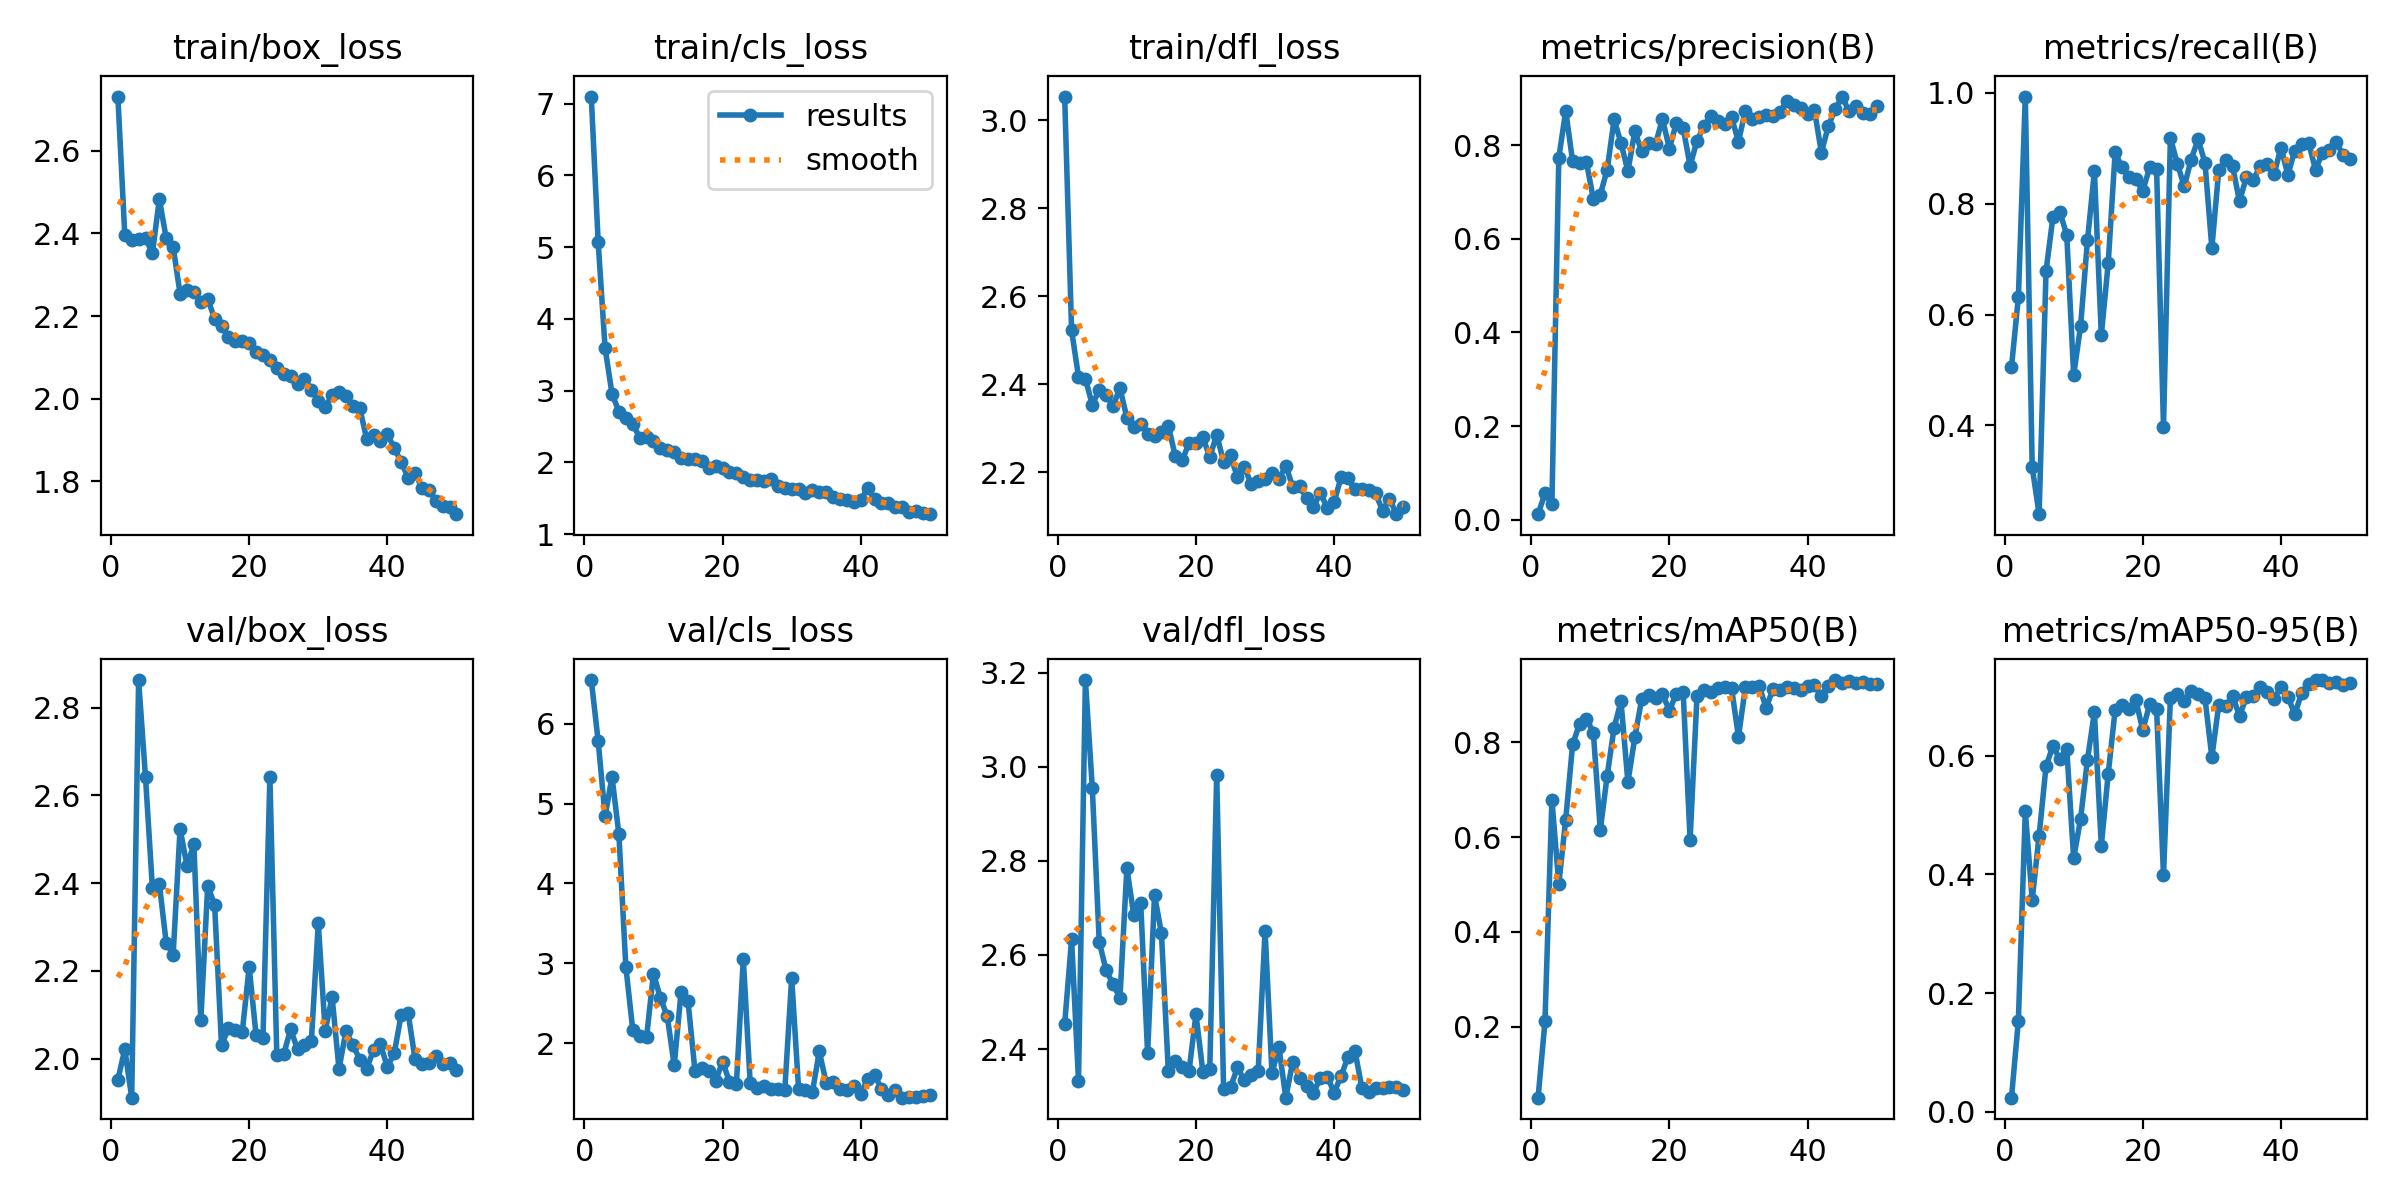

In [12]:
from IPython.display import Image

# Display the results image
Image(filename='/content/runs/detect/train/results.png')


# Creating Frontend user interface using gradio .


In [17]:
import gradio as gr
from ultralytics import YOLO
import os
import glob
# Load the trained YOLOv10 model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Inference function for Gradio
def detect_objects(image):
    # Run prediction
    results = model.predict(source=image, save=True, conf=0.5)

    # Get the path of the saved image
    predicted_image_dir = 'runs/detect/predict'
    predicted_image_path = glob.glob(f"{predicted_image_dir}/*")

    return predicted_image_path[0]

# Create the Gradio interface
app = gr.Interface(
    fn=detect_objects,
    inputs=gr.Image(type="filepath", label="Upload Image"),
    outputs=gr.Image(type="filepath", label="Detected Image"),
    title="YOLOv10 Object Detection App",
    description="Upload an image to detect blood cells (RBC, WBC, Platelets) using the fine-tuned YOLOv10 model."
)

# Launch the app
app.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://108e3f1a51b7e268f2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
